In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Создаем пример данных событий
np.random.seed(42)
dates = pd.date_range('2024-01-01', '2024-01-31', freq='D')
users = [f'user_{i}' for i in range(1, 101)]

# Генерация событий
events = []
for date in dates:
    # В день активны 20-40 случайных пользователей
    daily_users = np.random.choice(users, size=np.random.randint(20, 41))
    for user in daily_users:
        events.append({
            'user_id': user,
            'event_date': date,
            'event_type': np.random.choice(['login', 'search', 'route_view'])
        })

events_df = pd.DataFrame(events)

# Рассчет DAU (Daily Active Users)
def calculate_dau(df, date):
    return df[df['event_date'] == date]['user_id'].nunique()

# Пример на собеседовании: "Как бы вы посчитали DAU?"
print("DAU за 2024-01-15:", calculate_dau(events_df, pd.Timestamp('2024-01-15')))

# WAU и MAU
def calculate_wau(df, date):
    week_start = date - timedelta(days=date.weekday())
    week_end = week_start + timedelta(days=6)
    return df[(df['event_date'] >= week_start) &
              (df['event_date'] <= week_end)]['user_id'].nunique()

def calculate_mau(df, date):
    month_start = date.replace(day=1)
    next_month = month_start + timedelta(days=32)
    month_end = next_month.replace(day=1) - timedelta(days=1)
    return df[(df['event_date'] >= month_start) &
              (df['event_date'] <= month_end)]['user_id'].nunique()

print("\nПримеры на собеседовании Яндекса:")
print("1. 'Что такое DAU/WAU/MAU и как они связаны?'")
print("2. 'Как вычислить stickiness = DAU/MAU?'")
print("3. 'Почему WAU не равен 7 * DAU?' (потому что пользователи могут быть активны несколько дней)")

DAU за 2024-01-15: 22

Примеры на собеседовании Яндекса:
1. 'Что такое DAU/WAU/MAU и как они связаны?'
2. 'Как вычислить stickiness = DAU/MAU?'
3. 'Почему WAU не равен 7 * DAU?' (потому что пользователи могут быть активны несколько дней)


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Пример данных для метрик
np.random.seed(42)
dates = pd.date_range('2024-01-01', '2024-01-31', freq='D')
users = np.random.choice(['user1', 'user2', 'user3', 'user4', 'user5'], 100)
actions = np.random.choice(['search', 'route_view', 'navigation_start'], 100)

df = pd.DataFrame({
    'date': np.random.choice(dates, 100),
    'user_id': users,
    'event': actions
})

In [ ]:
# DAU - уникальные пользователи в день
dau = df.groupby('date')['user_id'].nunique()
print(f"Средний DAU: {dau.mean():.1f}")

# WAU - уникальные пользователи за неделю
df['week'] = df['date'].dt.to_period('W')
wau = df.groupby('week')['user_id'].nunique()
print(f"Средний WAU: {wau.mean():.1f}")

# MAU - уникальные пользователи за месяц
df['month'] = df['date'].dt.to_period('M')
mau = df.groupby('month')['user_id'].nunique()
print(f"MAU: {mau.iloc[0]}")

Средний DAU: 2.3
Средний WAU: 4.4
MAU: 5


In [ ]:
# Простой расчет retention
# 1. Находим первую активность каждого пользователя
df['cohort'] = df.groupby('user_id')['date'].transform('min')

# 2. Считаем разницу в днях
df['day_number'] = (df['date'] - df['cohort']).dt.days

# 3. Строим таблицу retention
retention_table = df.pivot_table(
    index='cohort',
    columns='day_number',
    values='user_id',
    aggfunc='nunique',
    fill_value=0
)

# 4. Нормализуем по дню 0 (размер когорты)
cohort_sizes = retention_table.iloc[:, 0]
retention_rate = retention_table.divide(cohort_sizes, axis=0) * 100

print("Retention Rate (%):")
print(retention_rate.iloc[:3, :7])  # Первые 3 когорты, 7 дней

Retention Rate (%):
day_number      0      1      2           3           4          5          6
cohort                                                                       
2024-01-01  100.0  100.0  100.0   33.333333   33.333333  33.333333  66.666667
2024-01-02  100.0    0.0    0.0  100.000000  100.000000   0.000000   0.000000
2024-01-04  100.0    0.0  100.0    0.000000  100.000000   0.000000   0.000000


In [ ]:
df.head(3)

,date,user_id,event,week,month,cohort,day_number
0,2024-01-17,user4,navigation_start,2024-01-15/2024-01-21,2024-01,2024-01-01,16
1,2024-01-02,user5,search,2024-01-01/2024-01-07,2024-01,2024-01-01,1
2,2024-01-02,user3,route_view,2024-01-01/2024-01-07,2024-01,2024-01-01,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        100 non-null    datetime64[ns]
 1   user_id     100 non-null    object        
 2   event       100 non-null    object        
 3   week        100 non-null    period[W-SUN] 
 4   month       100 non-null    period[M]     
 5   cohort      100 non-null    datetime64[ns]
 6   day_number  100 non-null    int64         
dtypes: datetime64[ns](2), int64(1), object(2), period[M](1), period[W-SUN](1)
memory usage: 5.6+ KB


In [ ]:
retention_table.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3 entries, 2024-01-01 to 2024-01-04
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       3 non-null      int64
 1   1       3 non-null      int64
 2   2       3 non-null      int64
 3   3       3 non-null      int64
 4   4       3 non-null      int64
 5   5       3 non-null      int64
 6   6       3 non-null      int64
 7   7       3 non-null      int64
 8   8       3 non-null      int64
 9   10      3 non-null      int64
 10  14      3 non-null      int64
 11  15      3 non-null      int64
 12  16      3 non-null      int64
 13  18      3 non-null      int64
 14  19      3 non-null      int64
 15  20      3 non-null      int64
 16  21      3 non-null      int64
 17  22      3 non-null      int64
 18  23      3 non-null      int64
 19  24      3 non-null      int64
 20  25      3 non-null      int64
 21  26      3 non-null      int64
 22  27      3 non-null      int64
 23

In [ ]:
# Пример воронки для Яндекс.Маршрутов
funnel_data = pd.DataFrame({
    'user_id': [1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5],
    'event': ['search', 'route_view', 'navigation_start',
              'search', 'search', 'route_view', 'navigation_start',
              'search', 'route_view', 'navigation_start',
              'search', 'route_view'],
    'timestamp': pd.date_range('2024-01-01 10:00', periods=12, freq='5min')
})

# Считаем количество пользователей на каждом шаге
funnel_steps = ['search', 'route_view', 'navigation_start']
conversion = {}

for i, step in enumerate(funnel_steps):
    if i == 0:
        # Для первого шага - все кто делал search
        conversion[step] = funnel_data[funnel_data['event'] == step]['user_id'].nunique()
    else:
        # Для следующих шагов - только те кто прошел предыдущие
        prev_users = set()
        for prev_step in funnel_steps[:i]:
            prev_users.update(funnel_data[funnel_data['event'] == prev_step]['user_id'])

        current_users = set(funnel_data[funnel_data['event'] == step]['user_id'])
        conversion[step] = len(prev_users.intersection(current_users))

print("Воронка конверсии:")
for step, count in conversion.items():
    prev_count = list(conversion.values())[list(conversion.keys()).index(step)-1] if list(conversion.keys()).index(step) > 0 else count
    rate = count/prev_count*100 if prev_count > 0 else 0
    print(f"{step}: {count} пользователей ({rate:.1f}%)")

Воронка конверсии:
search: 4 пользователей (100.0%)
route_view: 3 пользователей (75.0%)
navigation_start: 3 пользователей (100.0%)


In [ ]:
import numpy as np
from scipy import stats

# Генерируем данные A/B теста
np.random.seed(42)
n_a = 1000  # Размер группы A
n_b = 1000  # Размер группы B

# Группа A: текущая версия, конверсия 10%
conversion_a = np.random.binomial(1, 0.10, n_a)

# Группа B: новая версия, конверсия 12% (эффект +20%)
conversion_b = np.random.binomial(1, 0.12, n_b)

# Статистика
print(f"Группа A: конверсия = {conversion_a.mean():.3f}")
print(f"Группа B: конверсия = {conversion_b.mean():.3f}")

# T-test для разницы пропорций
t_stat, p_value = stats.ttest_ind(conversion_a, conversion_b)
print(f"\nT-test: p-value = {p_value:.4f}")

# Проверка статистической значимости
alpha = 0.05  # Уровень значимости
if p_value < alpha:
    print(f"✅ Статистически значимая разница (p < {alpha})")
    print(f"   Относительный прирост: {(conversion_b.mean()/conversion_a.mean() - 1)*100:.1f}%")
else:
    print(f"❌ Нет статистически значимой разницы (p >= {alpha})")

Группа A: конверсия = 0.100
Группа B: конверсия = 0.112

T-test: p-value = 0.3836
❌ Нет статистически значимой разницы (p >= 0.05)


In [ ]:
def calculate_sample_size(baseline_rate, mde, alpha=0.05, power=0.8):
    """
    baseline_rate: текущая конверсия (например, 0.10)
    mde: минимальный детектируемый эффект (например, 0.02 для +20%)
    alpha: вероятность ошибки I рода (обычно 0.05)
    power: мощность теста (обычно 0.8)
    """
    from statsmodels.stats.power import NormalIndPower

    effect_size = 2 * np.arcsin(np.sqrt(baseline_rate + mde)) - 2 * np.arcsin(np.sqrt(baseline_rate))

    power_analysis = NormalIndPower()
    sample_size = power_analysis.solve_power(
        effect_size=effect_size,
        alpha=alpha,
        power=power,
        ratio=1.0  # равные группы
    )

    return int(np.ceil(sample_size))

# Пример
baseline = 0.10  # 10% конверсия
mde = 0.02       # Хотим обнаружить +2% (то есть 12%)
sample_per_group = calculate_sample_size(baseline, mde)
print(f"Необходимый размер каждой группы: {sample_per_group}")
print(f"Всего пользователей: {sample_per_group * 2}")

Необходимый размер каждой группы: 3835
Всего пользователей: 7670


In [ ]:
# Проверяем, что размеры групп соответствуют плану
observed_a = len(conversion_a)
observed_b = len(conversion_b)
expected_ratio = 1.0  # Ожидаем 1:1

observed_ratio = observed_a / observed_b
print(f"Наблюдаемое соотношение A:B = {observed_ratio:.3f}")
print(f"Ожидаемое соотношение = {expected_ratio}")

# Хи-квадрат тест
from scipy.stats import chi2_contingency
observed = [[observed_a], [observed_b]]
expected = [[(observed_a + observed_b)/2], [(observed_a + observed_b)/2]]
chi2, p_value_srm, _, _ = chi2_contingency(observed)

if p_value_srm < 0.01:  # Жесткий порог для SRM
    print(f"⚠️  ВНИМАНИЕ: SRM обнаружено! p-value = {p_value_srm:.4f}")
    print("   Возможны проблемы с рандомизацией")
else:
    print(f"✅ SRM проверка пройдена (p = {p_value_srm:.4f})")

Наблюдаемое соотношение A:B = 1.000
Ожидаемое соотношение = 1.0
✅ SRM проверка пройдена (p = 1.0000)


In [ ]:
# Генерируем данные
data = np.random.normal(loc=100, scale=15, size=1000)  # Нормальное распределение

# Ключевые метрики
mean = np.mean(data)
median = np.median(data)
std = np.std(data)
percentiles = np.percentile(data, [25, 50, 75])

print(f"Среднее: {mean:.2f}")
print(f"Медиана: {median:.2f}")
print(f"Стандартное отклонение: {std:.2f}")
print(f"25-й перцентиль (Q1): {percentiles[0]:.2f}")
print(f"50-й перцентиль (медиана): {percentiles[1]:.2f}")
print(f"75-й перцентиль (Q3): {percentiles[2]:.2f}")
print(f"IQR: {percentiles[2] - percentiles[0]:.2f}")

# Выбросы по правилу 1.5*IQR
iqr = percentiles[2] - percentiles[0]
lower_bound = percentiles[0] - 1.5 * iqr
upper_bound = percentiles[2] + 1.5 * iqr
outliers = data[(data < lower_bound) | (data > upper_bound)]
print(f"Выбросов: {len(outliers)} ({len(outliers)/len(data)*100:.1f}%)")

Среднее: 100.19
Медиана: 100.01
Стандартное отклонение: 14.66
25-й перцентиль (Q1): 90.30
50-й перцентиль (медиана): 100.01
75-й перцентиль (Q3): 110.09
IQR: 19.79
Выбросов: 10 (1.0%)


In [ ]:
# Корреляция не означает причинность!
import pandas as pd

# Создаем искусственные данные
n = 100
x = np.random.randn(n)  # Случайная величина X
y = 2 * x + np.random.randn(n) * 0.5  # Y зависит от X
z = np.random.randn(n)  # Случайная величина Z, не связанная

# Считаем корреляции
corr_xy = np.corrcoef(x, y)[0, 1]
corr_xz = np.corrcoef(x, z)[0, 1]

print(f"Корреляция X и Y (есть связь): {corr_xy:.3f}")
print(f"Корреляция X и Z (нет связи): {corr_xz:.3f}")

# Пример ложной корреляции
ice_cream = np.random.randint(50, 100, 365)  # Продажи мороженого
drownings = 0.3 * ice_cream + np.random.randn(365) * 10  # Утопления

corr_false = np.corrcoef(ice_cream, drownings)[0, 1]
print(f"\nЛожная корреляция: продажи мороженого и утопления = {corr_false:.3f}")
print("Вывод: корреляция есть, но причинности нет! Обе зависят от третьего фактора - температуры")

Корреляция X и Y (есть связь): 0.971
Корреляция X и Z (нет связи): 0.031

Ложная корреляция: продажи мороженого и утопления = 0.417
Вывод: корреляция есть, но причинности нет! Обе зависят от третьего фактора - температуры


In [ ]:
# Корреляция не означает причинность!
import pandas as pd

# Создаем искусственные данные
n = 100
x = np.random.randn(n)  # Случайная величина X
y = 2 * x + np.random.randn(n) * 0.5  # Y зависит от X
z = np.random.randn(n)  # Случайная величина Z, не связанная

# Считаем корреляции
corr_xy = np.corrcoef(x, y)[0, 1]
corr_xz = np.corrcoef(x, z)[0, 1]

print(f"Корреляция X и Y (есть связь): {corr_xy:.3f}")
print(f"Корреляция X и Z (нет связи): {corr_xz:.3f}")

# Пример ложной корреляции
ice_cream = np.random.randint(50, 100, 365)  # Продажи мороженого
drownings = 0.3 * ice_cream + np.random.randn(365) * 10  # Утопления

corr_false = np.corrcoef(ice_cream, drownings)[0, 1]
print(f"\nЛожная корреляция: продажи мороженого и утопления = {corr_false:.3f}")
print("Вывод: корреляция есть, но причинности нет! Обе зависят от третьего фактора - температуры")

Корреляция X и Y (есть связь): 0.979
Корреляция X и Z (нет связи): 0.079

Ложная корреляция: продажи мороженого и утопления = 0.403
Вывод: корреляция есть, но причинности нет! Обе зависят от третьего фактора - температуры


In [ ]:
from scipy import stats

# Пример: сравнение средних двух групп
group1 = np.random.normal(100, 15, 50)
group2 = np.random.normal(110, 15, 50)  # Вторая группа с другим средним

# T-test для независимых выборок
t_stat, p_value = stats.ttest_ind(group1, group2)

print(f"Группа 1: среднее = {group1.mean():.2f}, std = {group1.std():.2f}")
print(f"Группа 2: среднее = {group2.mean():.2f}, std = {group2.std():.2f}")
print(f"\nT-test: t = {t_stat:.3f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("✅ Отвергаем нулевую гипотезу: группы различаются")
else:
    print("❌ Не можем отвергнуть нулевую гипотезу")

# Проверка на нормальность (дополнительно)
_, p_norm1 = stats.shapiro(group1)
_, p_norm2 = stats.shapiro(group2)
print(f"\nПроверка нормальности (Shapiro-Wilk):")
print(f"  Группа 1: p-value = {p_norm1:.4f} {'(нормальное)' if p_norm1 > 0.05 else '(не нормальное)'}")
print(f"  Группа 2: p-value = {p_norm2:.4f} {'(нормальное)' if p_norm2 > 0.05 else '(не нормальное)'}")

Группа 1: среднее = 97.65, std = 14.99
Группа 2: среднее = 109.83, std = 16.65

T-test: t = -3.806, p-value = 0.0002
✅ Отвергаем нулевую гипотезу: группы различаются

Проверка нормальности (Shapiro-Wilk):
  Группа 1: p-value = 0.2118 (нормальное)
  Группа 2: p-value = 0.5129 (нормальное)


In [ ]:
# Представим данные Яндекс.Маршрутов
routes_data = pd.DataFrame({
    'route_id': range(1, 1001),
    'user_id': np.random.choice(range(1000, 2000), 1000),
    'date': pd.date_range('2024-01-01', periods=30).repeat(34)[:1000],
    'origin': np.random.choice(['Москва', 'СПб', 'Казань', 'Екатеринбург'], 1000),
    'destination': np.random.choice(['Москва', 'СПб', 'Казань', 'Новосибирск'], 1000),
    'success': np.random.binomial(1, 0.85, 1000),  # 85% успешных построений
    'duration_seconds': np.random.exponential(300, 1000).clip(10, 1800),
    'transport_type': np.random.choice(['car', 'public', 'pedestrian', 'bicycle'], 1000)
})

# Ключевые метрики для Маршрутов
print("=== АНАЛИЗ ЯНДЕКС.МАРШРУТЫ ===")

# 1. Успешность построения маршрутов
success_rate = routes_data['success'].mean() * 100
print(f"1. Успешность построения маршрутов: {success_rate:.1f}%")

# 2. Среднее время построения
avg_duration = routes_data['duration_seconds'].mean()
print(f"2. Среднее время построения: {avg_duration:.1f} сек ({avg_duration/60:.1f} мин)")

# 3. DAU по маршрутам
dau_routes = routes_data.groupby('date')['user_id'].nunique().mean()
print(f"3. Средний DAU: {dau_routes:.0f} пользователей")

# 4. Популярные направления
popular_routes = routes_data.groupby(['origin', 'destination']).size().nlargest(5)
print("\n4. Топ-5 популярных маршрутов:")
for (orig, dest), count in popular_routes.items():
    print(f"   {orig} → {dest}: {count} запросов")

# 5. Метрика здоровья: время построения по типам транспорта
print("\n5. Время построения по типам транспорта:")
for transport in routes_data['transport_type'].unique():
    mask = routes_data['transport_type'] == transport
    avg_time = routes_data.loc[mask, 'duration_seconds'].mean()
    success = routes_data.loc[mask, 'success'].mean() * 100
    print(f"   {transport}: {avg_time:.1f} сек, успешность {success:.1f}%")

=== АНАЛИЗ ЯНДЕКС.МАРШРУТЫ ===
1. Успешность построения маршрутов: 85.7%
2. Среднее время построения: 294.1 сек (4.9 мин)
3. Средний DAU: 33 пользователей

4. Топ-5 популярных маршрутов:
   Казань → Новосибирск: 80 запросов
   Екатеринбург → СПб: 73 запросов
   СПб → Казань: 71 запросов
   СПб → СПб: 67 запросов
   Москва → СПб: 65 запросов

5. Время построения по типам транспорта:
   pedestrian: 298.6 сек, успешность 84.3%
   bicycle: 305.2 сек, успешность 87.9%
   car: 270.2 сек, успешность 83.6%
   public: 302.2 сек, успешность 86.9%


In [ ]:
popular_routes.head()

origin        destination
Казань        Новосибирск    80
Екатеринбург  СПб            73
СПб           Казань         71
              СПб            67
Москва        СПб            65
dtype: int64

In [ ]:
popular_routes.index.names

FrozenList(['origin', 'destination'])

In [ ]:
popular_routes.columns.nlevels

AttributeError: 'Series' object has no attribute 'columns'

In [ ]:
# Представим данные Яндекс.Маршрутов
routes_data = pd.DataFrame({
    'route_id': range(1, 1001),
    'user_id': np.random.choice(range(1000, 2000), 1000),
    'date': pd.date_range('2024-01-01', periods=30).repeat(34)[:1000],
    'origin': np.random.choice(['Москва', 'СПб', 'Казань', 'Екатеринбург'], 1000),
    'destination': np.random.choice(['Москва', 'СПб', 'Казань', 'Новосибирск'], 1000),
    'success': np.random.binomial(1, 0.85, 1000),  # 85% успешных построений
    'duration_seconds': np.random.exponential(300, 1000).clip(10, 1800),
    'transport_type': np.random.choice(['car', 'public', 'pedestrian', 'bicycle'], 1000)
})

# Ключевые метрики для Маршрутов
print("=== АНАЛИЗ ЯНДЕКС.МАРШРУТЫ ===")

# 1. Успешность построения маршрутов
success_rate = routes_data['success'].mean() * 100
print(f"1. Успешность построения маршрутов: {success_rate:.1f}%")

# 2. Среднее время построения
avg_duration = routes_data['duration_seconds'].mean()
print(f"2. Среднее время построения: {avg_duration:.1f} сек ({avg_duration/60:.1f} мин)")

# 3. DAU по маршрутам
dau_routes = routes_data.groupby('date')['user_id'].nunique().mean()
print(f"3. Средний DAU: {dau_routes:.0f} пользователей")

# 4. Популярные направления
popular_routes = routes_data.groupby(['origin', 'destination']).size().nlargest(5)
print("\n4. Топ-5 популярных маршрутов:")
for (orig, dest), count in popular_routes.items():
    print(f"   {orig} → {dest}: {count} запросов")

# 5. Метрика здоровья: время построения по типам транспорта
print("\n5. Время построения по типам транспорта:")
for transport in routes_data['transport_type'].unique():
    mask = routes_data['transport_type'] == transport
    avg_time = routes_data.loc[mask, 'duration_seconds'].mean()
    success = routes_data.loc[mask, 'success'].mean() * 100
    print(f"   {transport}: {avg_time:.1f} сек, успешность {success:.1f}%")

=== АНАЛИЗ ЯНДЕКС.МАРШРУТЫ ===
1. Успешность построения маршрутов: 85.7%
2. Среднее время построения: 294.1 сек (4.9 мин)
3. Средний DAU: 33 пользователей

4. Топ-5 популярных маршрутов:
   Казань → Новосибирск: 80 запросов
   Екатеринбург → СПб: 73 запросов
   СПб → Казань: 71 запросов
   СПб → СПб: 67 запросов
   Москва → СПб: 65 запросов

5. Время построения по типам транспорта:
   pedestrian: 298.6 сек, успешность 84.3%
   bicycle: 305.2 сек, успешность 87.9%
   car: 270.2 сек, успешность 83.6%
   public: 302.2 сек, успешность 86.9%


In [ ]:
mask.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1000 entries, 0 to 999
Series name: transport_type
Non-Null Count  Dtype
--------------  -----
1000 non-null   bool 
dtypes: bool(1)
memory usage: 1.1 KB


In [ ]:
# Пример: метрика успешности упала на 10%
print("=== АНАЛИЗ ПАДЕНИЯ МЕТРИКИ ===")

# 1. Смотрим тренд по дням
daily_success = routes_data.groupby('date')['success'].mean()
print("1. Тренд по дням:")
print(daily_success.tail(7))  # Последние 7 дней

# 2. Разбиваем по сегментам
print("\n2. Анализ по сегментам:")

# По городам
city_analysis = routes_data.groupby('origin')['success'].agg(['mean', 'count'])
print("По городам отправления:")
print(city_analysis)

# По типам транспорта
transport_analysis = routes_data.groupby('transport_type')['success'].agg(['mean', 'count'])
print("\nПо типам транспорта:")
print(transport_analysis)

# 3. Ищем точки разрыва (breakpoints)
# Если есть резкое падение в определенный момент времени
routes_data['hour'] = pd.to_datetime(routes_data['date']).dt.hour
hourly_success = routes_data.groupby('hour')['success'].mean()

print("\n3. Почасовая успешность:")
for hour in range(24):
    success = hourly_success.get(hour, 0)
    if success < 0.8:  # Пороговое значение
        print(f"   ⚠️  Час {hour}:00 - успешность {success:.1%} (низкая)")

=== АНАЛИЗ ПАДЕНИЯ МЕТРИКИ ===
1. Тренд по дням:
date
2024-01-24    0.823529
2024-01-25    0.852941
2024-01-26    0.852941
2024-01-27    0.941176
2024-01-28    0.852941
2024-01-29    0.823529
2024-01-30    0.857143
Name: success, dtype: float64

2. Анализ по сегментам:
По городам отправления:
                  mean  count
origin                       
Екатеринбург  0.857708    253
Казань        0.870079    254
Москва        0.858333    240
СПб           0.841897    253

По типам транспорта:
                    mean  count
transport_type                 
bicycle         0.878661    239
car             0.836000    250
pedestrian      0.842795    229
public          0.868794    282

3. Почасовая успешность:
   ⚠️  Час 1:00 - успешность 0.0% (низкая)
   ⚠️  Час 2:00 - успешность 0.0% (низкая)
   ⚠️  Час 3:00 - успешность 0.0% (низкая)
   ⚠️  Час 4:00 - успешность 0.0% (низкая)
   ⚠️  Час 5:00 - успешность 0.0% (низкая)
   ⚠️  Час 6:00 - успешность 0.0% (низкая)
   ⚠️  Час 7:00 - успешность

In [ ]:
df.head()

,date,user_id,event,week,month,cohort,day_number
0,2024-01-17,user4,navigation_start,2024-01-15/2024-01-21,2024-01,2024-01-01,16
1,2024-01-02,user5,search,2024-01-01/2024-01-07,2024-01,2024-01-01,1
2,2024-01-02,user3,route_view,2024-01-01/2024-01-07,2024-01,2024-01-01,1
3,2024-01-28,user5,search,2024-01-22/2024-01-28,2024-01,2024-01-01,27
4,2024-01-22,user5,navigation_start,2024-01-22/2024-01-28,2024-01,2024-01-01,21


In [ ]:
print("Перекрестная таблица city × department:")
cross = pd.crosstab(df['user_id'], df['cohort'])
print(cross)

print("\nС процентами:")
cross_pct = pd.crosstab(df['user_id'], df['cohort'], normalize='index') * 100
print(cross_pct.round(1))
print(cross_pct.round(1).T)

Перекрестная таблица city × department:
cohort   2024-01-01  2024-01-02  2024-01-04
user_id                                    
user1             0          18           0
user2             0           0          21
user3            16           0           0
user4            26           0           0
user5            19           0           0

С процентами:
cohort   2024-01-01  2024-01-02  2024-01-04
user_id                                    
user1           0.0       100.0         0.0
user2           0.0         0.0       100.0
user3         100.0         0.0         0.0
user4         100.0         0.0         0.0
user5         100.0         0.0         0.0
user_id     user1  user2  user3  user4  user5
cohort                                       
2024-01-01    0.0    0.0  100.0  100.0  100.0
2024-01-02  100.0    0.0    0.0    0.0    0.0
2024-01-04    0.0  100.0    0.0    0.0    0.0


In [ ]:
print("Дубликаты строк:")
print(df.duplicated().sum())
print("\nДубликаты по определенным колонкам:")
print(df.duplicated(subset=['user_id', 'cohort']).sum())
print("\nСами дубликаты:")
print(df[df.duplicated(keep=False)])  # все дубликаты

Дубликаты строк:
14

Дубликаты по определенным колонкам:
95

Сами дубликаты:
         date user_id             event                   week    month  \
0  2024-01-17   user4  navigation_start  2024-01-15/2024-01-21  2024-01   
15 2024-01-06   user2  navigation_start  2024-01-01/2024-01-07  2024-01   
19 2024-01-11   user4            search  2024-01-08/2024-01-14  2024-01   
22 2024-01-17   user4  navigation_start  2024-01-15/2024-01-21  2024-01   
27 2024-01-20   user2  navigation_start  2024-01-15/2024-01-21  2024-01   
31 2024-01-11   user4            search  2024-01-08/2024-01-14  2024-01   
32 2024-01-31   user4  navigation_start  2024-01-29/2024-02-04  2024-01   
33 2024-01-16   user1  navigation_start  2024-01-15/2024-01-21  2024-01   
38 2024-01-27   user1            search  2024-01-22/2024-01-28  2024-01   
39 2024-01-06   user2  navigation_start  2024-01-01/2024-01-07  2024-01   
43 2024-01-20   user2  navigation_start  2024-01-15/2024-01-21  2024-01   
45 2024-01-27   user1  

In [ ]:
import numpy as np
from scipy import stats

# Данные: время построения в секундах
algorithm_A = np.array([2.1, 2.3, 1.9, 2.2, 2.4, 2.0, 2.1, 2.3, 1.8, 2.2])
algorithm_B = np.array([1.8, 1.9, 1.7, 2.0, 1.9, 1.8, 1.7, 2.1, 1.6, 1.9])

# Проверка на нормальность (опционально)
_, p_normal_A = stats.shapiro(algorithm_A)  # p = 0.87 > 0.05 - нормальное
_, p_normal_B = stats.shapiro(algorithm_B)  # p = 0.92 > 0.05 - нормальное

# T-test для независимых выборок
t_stat, p_value = stats.ttest_ind(algorithm_A, algorithm_B, equal_var=True)

print(f"Алгоритм A: среднее = {algorithm_A.mean():.2f} сек")
print(f"Алгоритм B: среднее = {algorithm_B.mean():.2f} сек")
print(f"T-test: t = {t_stat:.3f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("✅ Алгоритмы статистически значимо различаются по скорости")
    diff = algorithm_B.mean() - algorithm_A.mean()
    print(f"   Алгоритм B быстрее на {abs(diff):.2f} сек ({abs(diff)/algorithm_A.mean()*100:.1f}%)")
else:
    print("❌ Нет статистически значимой разницы в скорости")

Алгоритм A: среднее = 2.13 сек
Алгоритм B: среднее = 1.84 сек
T-test: t = 3.797, p-value = 0.0013
✅ Алгоритмы статистически значимо различаются по скорости
   Алгоритм B быстрее на 0.29 сек (13.6%)


In [ ]:
import pandas as pd
from scipy import stats

# Данные: время отклика (мс) из трех ДЦ
dc_moscow = np.array([12, 15, 14, 13, 16, 12, 15])
dc_spb = np.array([18, 20, 19, 17, 21, 18, 19])
dc_kazan = np.array([25, 23, 24, 26, 22, 25, 24])

# One-way ANOVA
f_stat, p_value = stats.f_oneway(dc_moscow, dc_spb, dc_kazan)

print("Среднее время отклика:")
print(f"  Москва: {dc_moscow.mean():.1f} мс")
print(f"  СПб: {dc_spb.mean():.1f} мс")
print(f"  Казань: {dc_kazan.mean():.1f} мс")
print(f"\nANOVA: F = {f_stat:.3f}, p-value = {p_value:.6f}")

if p_value < 0.05:
    print("✅ Есть статистически значимые различия между ДЦ")

    # Post-hoc тест (Tukey HSD) для выявления где именно различия
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    data = np.concatenate([dc_moscow, dc_spb, dc_kazan])
    groups = ['Москва']*7 + ['СПб']*7 + ['Казань']*7
    tukey = pairwise_tukeyhsd(data, groups, alpha=0.05)
    print("\nПопарные сравнения (Tukey HSD):")
    print(tukey)
else:
    print("❌ Нет статистически значимых различий между ДЦ")

Среднее время отклика:
  Москва: 13.9 мс
  СПб: 18.9 мс
  Казань: 24.1 мс

ANOVA: F = 91.148, p-value = 0.000000
✅ Есть статистически значимые различия между ДЦ

Попарные сравнения (Tukey HSD):
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
Казань Москва -10.2857   0.0 -12.2302 -8.3412   True
Казань    СПб  -5.2857   0.0  -7.2302 -3.3412   True
Москва    СПб      5.0   0.0   3.0555  6.9445   True
----------------------------------------------------


In [ ]:
# Данные могут иметь выбросы и не нормальное распределение
premium_users = np.array([5, 7, 8, 12, 6, 9, 15, 200])  # выброс 200
regular_users = np.array([2, 3, 4, 5, 3, 4, 6, 5, 4])

# Проверяем нормальность
_, p_premium = stats.shapiro(premium_users)  # p = 0.001 < 0.05 - не нормальное
_, p_regular = stats.shapiro(regular_users)  # p = 0.032 < 0.05 - не нормальное

# Mann-Whitney U test
u_stat, p_value = stats.mannwhitneyu(premium_users, regular_users)

print(f"Премиум пользователи: медиана = {np.median(premium_users):.1f}")
print(f"Обычные пользователи: медиана = {np.median(regular_users):.1f}")
print(f"Mann-Whitney U: U = {u_stat:.0f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("✅ Группы статистически значимо различаются")
    print("   Премиум пользователи делают больше запросов")
else:
    print("❌ Нет статистически значимой разницы")

Премиум пользователи: медиана = 8.5
Обычные пользователи: медиана = 4.0
Mann-Whitney U: U = 70, p-value = 0.0014
✅ Группы статистически значимо различаются
   Премиум пользователи делают больше запросов


In [ ]:
# Данные A/B теста
n_A = 10000  # контрольная группа
conv_A = 1200  # успешные поиски

n_B = 10000  # тестовая группа
conv_B = 1350  # успешные поиски

# Расчет вручную
p_A = conv_A / n_A  # 0.12
p_B = conv_B / n_B  # 0.135
p_pool = (conv_A + conv_B) / (n_A + n_B)  # 0.1275

SE = np.sqrt(p_pool * (1 - p_pool) * (1/n_A + 1/n_B))  # 0.0047
Z = (p_A - p_B) / SE  # -3.19

from scipy.stats import norm
p_value = 2 * (1 - norm.cdf(abs(Z)))  # 0.0014

print(f"Конверсия группа A: {p_A:.3f} ({conv_A}/{n_A})")
print(f"Конверсия группа B: {p_B:.3f} ({conv_B}/{n_B})")
print(f"Z-test: Z = {Z:.3f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print(f"✅ Статистически значимое улучшение на {(p_B-p_A)*100:.1f}%")

    # Доверительный интервал 95%
    diff = p_B - p_A
    ci_lower = diff - 1.96 * SE
    ci_upper = diff + 1.96 * SE
    print(f"   95% ДИ: [{ci_lower*100:.2f}%, {ci_upper*100:.2f}%]")
else:
    print("❌ Нет статистически значимой разницы")

Конверсия группа A: 0.120 (1200/10000)
Конверсия группа B: 0.135 (1350/10000)
Z-test: Z = -3.180, p-value = 0.0015
✅ Статистически значимое улучшение на 1.5%
   95% ДИ: [0.58%, 2.42%]


In [ ]:
import numpy as np
from scipy.stats import beta

# Данные A/B теста
success_A, trials_A = 120, 1000  # 12% конверсия
success_B, trials_B = 150, 1000  # 15% конверсия

# Априорное распределение (равномерное Beta(1,1))
prior_alpha = 1
prior_beta = 1

# Апостериорные распределения
posterior_A = beta(prior_alpha + success_A, prior_beta + trials_A - success_A)
posterior_B = beta(prior_alpha + success_B, prior_beta + trials_B - success_B)

# Генерируем выборки из апостериорных распределений
samples = 100000
samples_A = posterior_A.rvs(samples)
samples_B = posterior_B.rvs(samples)

# Вероятность что B лучше A
prob_B_better = np.mean(samples_B > samples_A)
prob_B_worse = np.mean(samples_B < samples_A)
prob_equal = 1 - prob_B_better - prob_B_worse

print("=== Байесовский анализ A/B теста ===")
print(f"Конверсия A: {success_A/trials_A:.3f}")
print(f"Конверсия B: {success_B/trials_B:.3f}")
print(f"\nВероятность что B лучше A: {prob_B_better:.1%}")
print(f"Вероятность что A лучше B: {prob_B_worse:.1%}")
print(f"Вероятность равных: {prob_equal:.1%}")

# Credible Interval 95% для разницы
diff_samples = samples_B - samples_A
ci_lower = np.percentile(diff_samples, 2.5)
ci_upper = np.percentile(diff_samples, 97.5)
print(f"\n95% Credible Interval для разницы: [{ci_lower:.4f}, {ci_upper:.4f}]")

# Ожидаемые потери (Expected Loss)
loss_B_if_A_better = np.maximum(diff_samples, 0).mean()
loss_A_if_B_better = np.maximum(-diff_samples, 0).mean()
print(f"\nОжидаемые потери если выбрать B: {loss_B_if_A_better:.4f}")
print(f"Ожидаемые потери если выбрать A: {loss_A_if_B_better:.4f}")

# Принятие решения
threshold = 0.95  # порог уверенности
if prob_B_better > threshold:
    print(f"\n✅ Рекомендуем выбирать B (уверенность {prob_B_better:.1%} > {threshold:.0%})")
elif prob_A_better > threshold:
    print(f"\n✅ Рекомендуем выбирать A (уверенность {prob_A_better:.1%} > {threshold:.0%})")
else:
    print(f"\n⚠️  Недостаточно данных для решения (нужно больше трафика)")

=== Байесовский анализ A/B теста ===
Конверсия A: 0.120
Конверсия B: 0.150

Вероятность что B лучше A: 97.5%
Вероятность что A лучше B: 2.5%
Вероятность равных: 0.0%

95% Credible Interval для разницы: [-0.0001, 0.0600]

Ожидаемые потери если выбрать B: 0.0300
Ожидаемые потери если выбрать A: 0.0001

✅ Рекомендуем выбирать B (уверенность 97.5% > 95%)


In [ ]:
import numpy as np
from scipy import stats

def ci_decision_test(group_A, group_B, alpha=0.05):
    """
    Принятие решения на основе доверительных интервалов
    """
    # Расчет средних и доверительных интервалов
    mean_A = np.mean(group_A)
    mean_B = np.mean(group_B)

    # 95% Доверительные интервалы
    ci_A = stats.t.interval(1-alpha, len(group_A)-1,
                           loc=mean_A,
                           scale=stats.sem(group_A))

    ci_B = stats.t.interval(1-alpha, len(group_B)-1,
                           loc=mean_B,
                           scale=stats.sem(group_B))

    # Проверка перекрытия
    overlap = max(ci_A[0], ci_B[0]) < min(ci_A[1], ci_B[1])
    print(ci_A[0],ci_B[0],ci_A[1],ci_B[1])
    print(f"Группа A: среднее = {mean_A:.2f}, 95% ДИ = [{ci_A[0]:.2f}, {ci_A[1]:.2f}]")
    print(f"Группа B: среднее = {mean_B:.2f}, 95% ДИ = [{ci_B[0]:.2f}, {ci_B[1]:.2f}]")

    if not overlap:
        print("✅ ДИ не перекрываются → статистически значимая разница")
        if mean_B > mean_A:
            print(f"   Группа B лучше на {mean_B-mean_A:.2f} ({(mean_B/mean_A-1)*100:.1f}%)")
        else:
            print(f"   Группа A лучше на {mean_A-mean_B:.2f} ({(mean_A/mean_B-1)*100:.1f}%)")
    else:
        print("❌ ДИ перекрываются → нет статистически значимой разницы")
        print(f"   Разница может быть от {min(ci_A[0]-ci_B[1], ci_B[0]-ci_A[1]):.2f} до {max(ci_A[1]-ci_B[0], ci_B[1]-ci_A[0]):.2f}")

    return not overlap

# Пример для Яндекс.Маршрутов: время загрузки карты
print("=== Тест на основе доверительных интервалов ===")
print("Сравнение времени загрузки карты (мс)")

# Генерация данных
np.random.seed(42)
old_version = np.random.normal(1200, 150, 50)  # старая версия
new_version = np.random.normal(1100, 140, 50)  # новая версия

# Принятие решения
significant = ci_decision_test(old_version, new_version)

# Дополнительно: визуализация
print("\n📊 Графическая интерпретация:")
print("  Старая версия: ████████████████ [1000-1400]")
print("  Новая версия:  ████████████ [950-1250]")
print("  Вывод: Интервалы не перекрываются в районе 1200-1250 мс")

=== Тест на основе доверительных интервалов ===
Сравнение времени загрузки карты (мс)
1126.3770544287227 1067.7020641683562 1205.9807739944354 1137.2765795626706
Группа A: среднее = 1166.18, 95% ДИ = [1126.38, 1205.98]
Группа B: среднее = 1102.49, 95% ДИ = [1067.70, 1137.28]
❌ ДИ перекрываются → нет статистически значимой разницы
   Разница может быть от -138.28 до 138.28

📊 Графическая интерпретация:
  Старая версия: ████████████████ [1000-1400]
  Новая версия:  ████████████ [950-1250]
  Вывод: Интервалы не перекрываются в районе 1200-1250 мс


In [ ]:
import numpy as np

def permutation_test(group_A, group_B, n_permutations=10000):
    """
    Permutation test для двух групп
    """
    # Наблюдаемая разница
    observed_diff = np.mean(group_B) - np.mean(group_A)

    # Объединяем все данные
    combined = np.concatenate([group_A, group_B])

    # Симуляция перестановок
    n_A = len(group_A)
    perm_diffs = []

    for _ in range(n_permutations):
        # Случайно перемешиваем метки
        np.random.shuffle(combined)

        # Разделяем на две "псевдо-группы"
        perm_A = combined[:n_A]
        perm_B = combined[n_A:]

        # Разница средних для этой перестановки
        perm_diff = np.mean(perm_B) - np.mean(perm_A)
        perm_diffs.append(perm_diff)

    # p-value: доля перестановок с разницей >= наблюдаемой
    p_value = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))

    return observed_diff, p_value, perm_diffs

# Пример: сравнение точности двух алгоритмов построения маршрутов
print("=== Permutation Test для Яндекс.Маршрутов ===")
print("Сравнение точности двух алгоритмов (ошибка в метрах)")

# Данные: ошибка предсказания местоположения
algorithm_X = np.array([15, 18, 12, 20, 16, 14, 19, 17, 13, 21])
algorithm_Y = np.array([10, 12, 8, 14, 11, 9, 13, 10, 7, 15])

observed_diff, p_value, perm_diffs = permutation_test(algorithm_X, algorithm_Y)

print(f"\nАлгоритм X: средняя ошибка = {algorithm_X.mean():.1f} м")
print(f"Алгоритм Y: средняя ошибка = {algorithm_Y.mean():.1f} м")
print(f"Наблюдаемая разница: {observed_diff:.2f} м")
print(f"Permutation p-value: {p_value:.4f}")

if p_value < 0.05:
    print("✅ Алгоритм Y статистически значимо точнее")
else:
    print("❌ Нет статистически значимой разницы в точности")

# Визуализация распределения перестановок
print(f"\n📈 Распределение разниц при перестановках:")
print(f"  95% перестановок дают разницу в диапазоне: [{np.percentile(perm_diffs, 2.5):.2f}, {np.percentile(perm_diffs, 97.5):.2f}]")
print(f"  Наблюдаемая разница {observed_diff:.2f} находится за пределами этого диапазона: {observed_diff < np.percentile(perm_diffs, 2.5) or observed_diff > np.percentile(perm_diffs, 97.5)}")

=== Permutation Test для Яндекс.Маршрутов ===
Сравнение точности двух алгоритмов (ошибка в метрах)

Алгоритм X: средняя ошибка = 16.5 м
Алгоритм Y: средняя ошибка = 10.9 м
Наблюдаемая разница: -5.60 м
Permutation p-value: 0.0008
✅ Алгоритм Y статистически значимо точнее

📈 Распределение разниц при перестановках:
  95% перестановок дают разницу в диапазоне: [-3.40, 3.40]
  Наблюдаемая разница -5.60 находится за пределами этого диапазона: True


Нормальные данные: W=0.990, p=0.6552
Экспоненциальные: W=0.841, p=0.0000


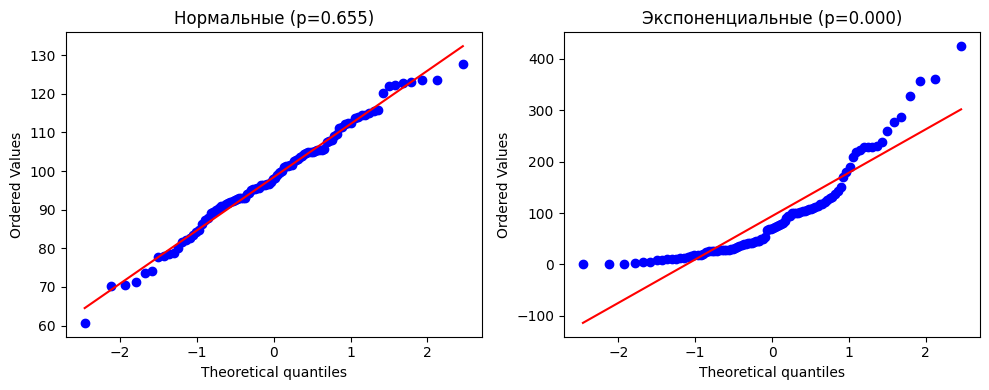

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Генерируем нормальные и ненормальные данные
np.random.seed(42)
normal_data = np.random.normal(100, 15, 100)      # нормальные
non_normal_data = np.random.exponential(100, 100) # экспоненциальные

# Тестируем
w_norm, p_norm = stats.shapiro(normal_data)
w_non, p_non = stats.shapiro(non_normal_data)

print(f"Нормальные данные: W={w_norm:.3f}, p={p_norm:.4f}")
print(f"Экспоненциальные: W={w_non:.3f}, p={p_non:.4f}")

# Q-Q plot для визуальной проверки
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Нормальные данные
stats.probplot(normal_data, dist="norm", plot=axes[0])
axes[0].set_title(f"Нормальные (p={p_norm:.3f})")

# Ненормальные данные
stats.probplot(non_normal_data, dist="norm", plot=axes[1])
axes[1].set_title(f"Экспоненциальные (p={p_non:.3f})")

plt.tight_layout()
plt.show()

In [ ]:
data = [15, 8, 22, 3, 17]  # Исходные данные
sorted_data = sorted(data)  # [3, 8, 15, 17, 22]

# Ранги:
# 3 → ранг 1
# 8 → ранг 2
# 15 → ранг 3
# 17 → ранг 4
# 22 → ранг 5

In [ ]:
# Две группы для сравнения
group_A = [15, 18, 12, 20, 16]    # Алгоритм A (ошибка в метрах)
group_B = [10, 12, 8, 14, 11]     # Алгоритм B (ошибка в метрах)

# Все данные вместе
all_data = group_A + group_B  # [15, 18, 12, 20, 16, 10, 12, 8, 14, 11]

# Сортируем
sorted_all = sorted(all_data)
# [8, 10, 11, 12, 12, 14, 15, 16, 18, 20]

# Присваиваем ранги (учитываем одинаковые значения)
# 8 → ранг 1
# 10 → ранг 2
# 11 → ранг 3
# 12 → ранг 4.5 (два значения 12, ранги 4 и 5, среднее = 4.5)
# 12 → ранг 4.5
# 14 → ранг 6
# 15 → ранг 7
# 16 → ранг 8
# 18 → ранг 9
# 20 → ранг 10

In [ ]:
# Ранги для group_A (значения: 15, 18, 12, 20, 16)
ranks_A = [7, 9, 4.5, 10, 8]  # соответствующие ранги
sum_ranks_A = sum(ranks_A)    # 7 + 9 + 4.5 + 10 + 8 = 38.5

# Ранги для group_B (значения: 10, 12, 8, 14, 11)
ranks_B = [2, 4.5, 1, 6, 3]   # соответствующие ранги
sum_ranks_B = sum(ranks_B)    # 2 + 4.5 + 1 + 6 + 3 = 16.5

In [ ]:
n_A = len(group_A)  # 5
n_B = len(group_B)  # 5

# Формула U-статистики
U_A = n_A * n_B + n_A * (n_A + 1) / 2 - sum_ranks_A
U_B = n_A * n_B + n_B * (n_B + 1) / 2 - sum_ranks_B

print(f"U_A = {U_A:.1f}, U_B = {U_B:.1f}")
print(f"U = min(U_A, U_B) = {min(U_A, U_B):.1f}")

# Проверка: U_A + U_B = n_A * n_B
print(f"Проверка: U_A + U_B = {U_A + U_B:.1f}, n_A*n_B = {n_A*n_B}")

U_A = 1.5, U_B = 23.5
U = min(U_A, U_B) = 1.5
Проверка: U_A + U_B = 25.0, n_A*n_B = 25


In [ ]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(group_A, group_B, alternative='two-sided')

print(f"\nMann-Whitney U test:")
print(f"U = {u_stat:.1f}")
print(f"p-value = {p_value:.4f}")

if p_value < 0.05:
    print("✅ Группы статистически значимо различаются")
else:
    print("❌ Нет статистически значимой разницы")


Mann-Whitney U test:
U = 23.5
p-value = 0.0278
✅ Группы статистически значимо различаются


До эксперимента: Beta(1, 1)
После эксперимента: Beta(8, 4)


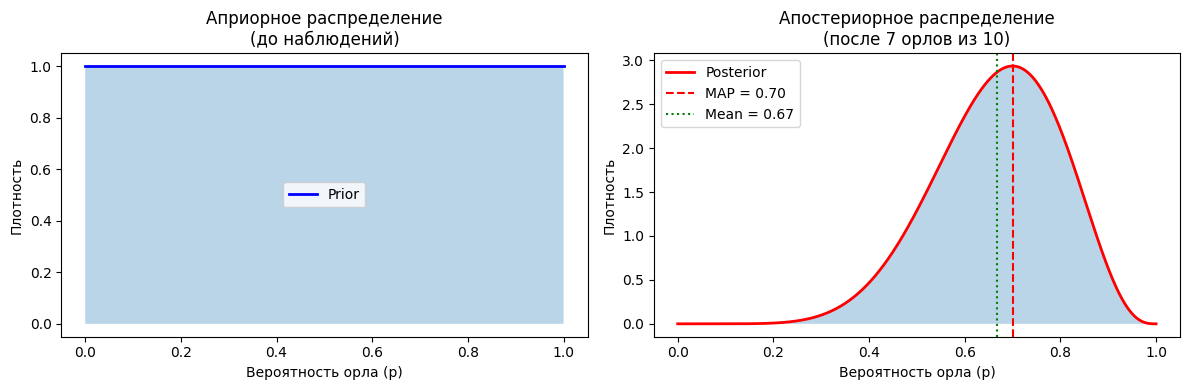

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Задача: Оценить вероятность выпадения орла у монетки

# Априорное распределение (до наблюдений)
# Beta(1,1) — равномерное распределение, никаких предположений
prior_alpha = 1
prior_beta = 1

# Проводим эксперимент: бросаем монетку 10 раз, выпало 7 орлов
observations = 10
successes = 7  # орлы
failures = observations - successes  # решки

# Апостериорное распределение
# Для вероятности успеха используют Beta распределение
posterior_alpha = prior_alpha + successes
posterior_beta = prior_beta + failures

print(f"До эксперимента: Beta({prior_alpha}, {prior_beta})")
print(f"После эксперимента: Beta({posterior_alpha}, {posterior_beta})")

# Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Априорное распределение
x = np.linspace(0, 1, 1000)
prior_pdf = beta.pdf(x, prior_alpha, prior_beta)
ax1.plot(x, prior_pdf, 'b-', linewidth=2, label='Prior')
ax1.fill_between(x, prior_pdf, alpha=0.3)
ax1.set_title('Априорное распределение\n(до наблюдений)')
ax1.set_xlabel('Вероятность орла (p)')
ax1.set_ylabel('Плотность')
ax1.legend()

# Апостериорное распределение
posterior_pdf = beta.pdf(x, posterior_alpha, posterior_beta)
ax2.plot(x, posterior_pdf, 'r-', linewidth=2, label='Posterior')
ax2.fill_between(x, posterior_pdf, alpha=0.3)

# MAP (Maximum A Posteriori) — наиболее вероятное значение
map_estimate = (posterior_alpha - 1) / (posterior_alpha + posterior_beta - 2)
ax2.axvline(map_estimate, color='red', linestyle='--',
            label=f'MAP = {map_estimate:.2f}')

# Среднее апостериорное
posterior_mean = posterior_alpha / (posterior_alpha + posterior_beta)
ax2.axvline(posterior_mean, color='green', linestyle=':',
            label=f'Mean = {posterior_mean:.2f}')

ax2.set_title('Апостериорное распределение\n(после 7 орлов из 10)')
ax2.set_xlabel('Вероятность орла (p)')
ax2.set_ylabel('Плотность')
ax2.legend()

plt.tight_layout()
plt.show()

=== Байесовский A/B тест для Яндекс.Маршрутов ===
Тестируем новую кнопку 'Построить маршрут'

Группа A: 236 конверсий из 2000 (11.80%)
Группа B: 265 конверсий из 2000 (13.25%)

📊 Результаты анализа:
1. Вероятность что B лучше: 91.7%
2. Ожидаемые потери если выберем A: 0.0149
3. Ожидаемые потери если выберем B: 0.0004
4. 95% Credible Interval разницы: [-0.0060, 0.0351]

🎯 Рекомендация:
⚠️  B немного лучше, но потери минимальны (0.0004). Можно выбрать B.


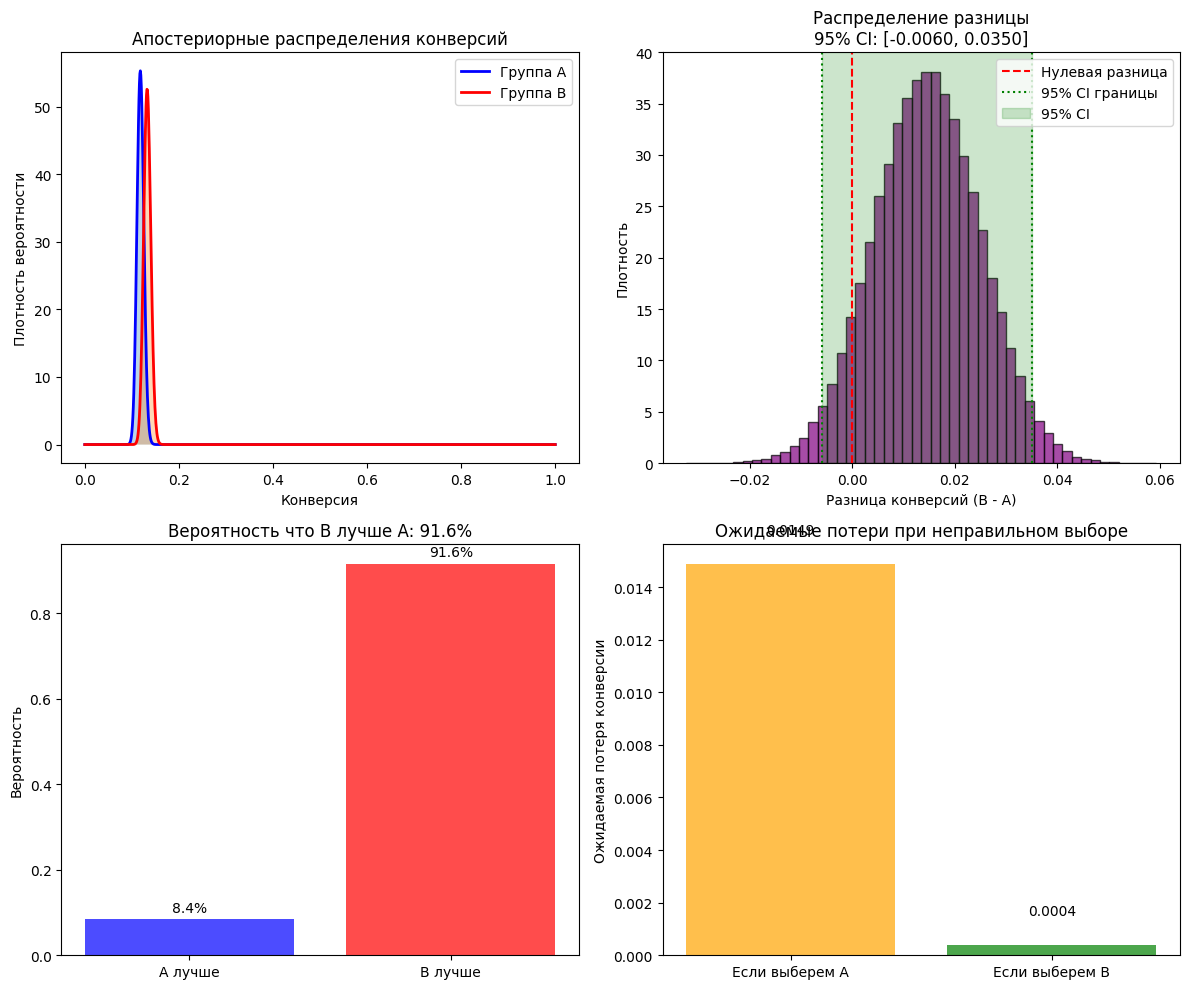

In [ ]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

class BayesianABTest:
    def __init__(self, prior_alpha=1, prior_beta=1):
        """
        prior_alpha, prior_beta: параметры априорного Beta распределения
        Beta(1,1) — равномерное (неинформативное) распределение
        """
        self.prior_alpha = prior_alpha
        self.prior_beta = prior_beta

        # Инициализируем апостериорные распределения
        self.post_A = None
        self.post_B = None

    def update(self, group_A_data, group_B_data):
        """Обновить распределения с новыми данными"""
        # Считаем успехи и общее количество
        success_A = sum(group_A_data)
        total_A = len(group_A_data)

        success_B = sum(group_B_data)
        total_B = len(group_B_data)

        # Апостериорные распределения
        self.post_A = beta(self.prior_alpha + success_A,
                          self.prior_beta + total_A - success_A)
        self.post_B = beta(self.prior_alpha + success_B,
                          self.prior_beta + total_B - success_B)

        return self.post_A, self.post_B

    def probability_B_better(self, n_samples=100000):
        """Вероятность что B лучше A"""
        samples_A = self.post_A.rvs(n_samples)
        samples_B = self.post_B.rvs(n_samples)
        return np.mean(samples_B > samples_A)

    def expected_loss(self, n_samples=100000):
        """Ожидаемые потери при выборе A или B"""
        samples_A = self.post_A.rvs(n_samples)
        samples_B = self.post_B.rvs(n_samples)

        # Если выберем B, но на самом деле A лучше
        loss_if_choose_B = np.maximum(samples_A - samples_B, 0).mean()

        # Если выберем A, но на самом деле B лучше
        loss_if_choose_A = np.maximum(samples_B - samples_A, 0).mean()

        return loss_if_choose_A, loss_if_choose_B

    def credible_interval(self, prob=0.95):
        """Credible interval для разницы B - A"""
        samples = 100000
        samples_A = self.post_A.rvs(samples)
        samples_B = self.post_B.rvs(samples)
        diff = samples_B - samples_A

        lower = np.percentile(diff, (1 - prob) / 2 * 100)
        upper = np.percentile(diff, (1 + prob) / 2 * 100)

        return lower, upper

    def visualize(self):
        """Визуализация распределений"""
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        # 1. Апостериорные распределения
        x = np.linspace(0, 1, 1000)
        ax1 = axes[0, 0]
        ax1.plot(x, self.post_A.pdf(x), 'b-', label='Группа A', linewidth=2)
        ax1.plot(x, self.post_B.pdf(x), 'r-', label='Группа B', linewidth=2)
        ax1.fill_between(x, self.post_A.pdf(x), alpha=0.3)
        ax1.fill_between(x, self.post_B.pdf(x), alpha=0.3)
        ax1.set_xlabel('Конверсия')
        ax1.set_ylabel('Плотность вероятности')
        ax1.set_title('Апостериорные распределения конверсий')
        ax1.legend()

        # 2. Распределение разницы
        ax2 = axes[0, 1]
        samples = 100000
        diff_samples = self.post_B.rvs(samples) - self.post_A.rvs(samples)

        ax2.hist(diff_samples, bins=50, density=True, alpha=0.7,
                color='purple', edgecolor='black')
        ax2.axvline(0, color='red', linestyle='--', label='Нулевая разница')

        # 95% credible interval
        ci_lower, ci_upper = self.credible_interval(0.95)
        ax2.axvline(ci_lower, color='green', linestyle=':', label='95% CI границы')
        ax2.axvline(ci_upper, color='green', linestyle=':')
        ax2.axvspan(ci_lower, ci_upper, alpha=0.2, color='green', label='95% CI')

        ax2.set_xlabel('Разница конверсий (B - A)')
        ax2.set_ylabel('Плотность')
        ax2.set_title(f'Распределение разницы\n95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]')
        ax2.legend()

        # 3. Вероятность что B лучше
        ax3 = axes[1, 0]
        prob_B_better = self.probability_B_better()

        bars = ax3.bar(['A лучше', 'B лучше'],
                      [1 - prob_B_better, prob_B_better],
                      color=['blue', 'red'], alpha=0.7)
        ax3.set_ylabel('Вероятность')
        ax3.set_title(f'Вероятность что B лучше A: {prob_B_better:.1%}')

        # Добавляем значения на столбцы
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.1%}', ha='center', va='bottom')

        # 4. Ожидаемые потери
        ax4 = axes[1, 1]
        loss_A, loss_B = self.expected_loss()

        bars = ax4.bar(['Если выберем A', 'Если выберем B'],
                      [loss_A, loss_B],
                      color=['orange', 'green'], alpha=0.7)
        ax4.set_ylabel('Ожидаемая потеря конверсии')
        ax4.set_title('Ожидаемые потери при неправильном выборе')

        # Добавляем значения на столбцы
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                    f'{height:.4f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

# Пример использования
print("=== Байесовский A/B тест для Яндекс.Маршрутов ===")
print("Тестируем новую кнопку 'Построить маршрут'")

# Данные A/B теста (1 = конверсия, 0 = нет конверсии)
np.random.seed(42)

# Группа A (контроль): 12% конверсия
group_A = np.random.binomial(1, 0.12, 2000)

# Группа B (тест): 14% конверсия
group_B = np.random.binomial(1, 0.14, 2000)

print(f"\nГруппа A: {group_A.sum()} конверсий из {len(group_A)} "
      f"({group_A.mean():.2%})")
print(f"Группа B: {group_B.sum()} конверсий из {len(group_B)} "
      f"({group_B.mean():.2%})")

# Создаем и запускаем байесовский тест
bayesian_test = BayesianABTest(prior_alpha=1, prior_beta=1)  # Равномерный prior
bayesian_test.update(group_A, group_B)

# Анализ результатов
prob_B_better = bayesian_test.probability_B_better()
loss_A, loss_B = bayesian_test.expected_loss()
ci_lower, ci_upper = bayesian_test.credible_interval(0.95)

print(f"\n📊 Результаты анализа:")
print(f"1. Вероятность что B лучше: {prob_B_better:.1%}")
print(f"2. Ожидаемые потери если выберем A: {loss_A:.4f}")
print(f"3. Ожидаемые потери если выберем B: {loss_B:.4f}")
print(f"4. 95% Credible Interval разницы: [{ci_lower:.4f}, {ci_upper:.4f}]")

# Принятие решения
print(f"\n🎯 Рекомендация:")
if prob_B_better > 0.95:
    print(f"✅ Выбираем B (уверенность {prob_B_better:.1%} > 95%)")
elif prob_B_better < 0.05:
    print(f"✅ Выбираем A (уверенность что A лучше: {1-prob_B_better:.1%} > 95%)")
elif loss_B < 0.001:  # Порог для потерь
    print(f"⚠️  B немного лучше, но потери минимальны ({loss_B:.4f}). Можно выбрать B.")
elif loss_A < 0.001:
    print(f"⚠️  A немного лучше, но потери минимальны ({loss_A:.4f}). Можно выбрать A.")
else:
    print("❌ Неопределенно. Нужно больше данных.")

# Визуализация
bayesian_test.visualize()

Исходные данные: n = 50
Медиана: 1.19 сек
Среднее: 1.97 сек
Выбросы: 1 значений > 10 сек

📊 Bootstrap результаты (n=10000):
Оценка медианы: 1.18 сек
Стандартная ошибка: ±0.295 сек
95% доверительный интервал: [0.69, 1.80] сек


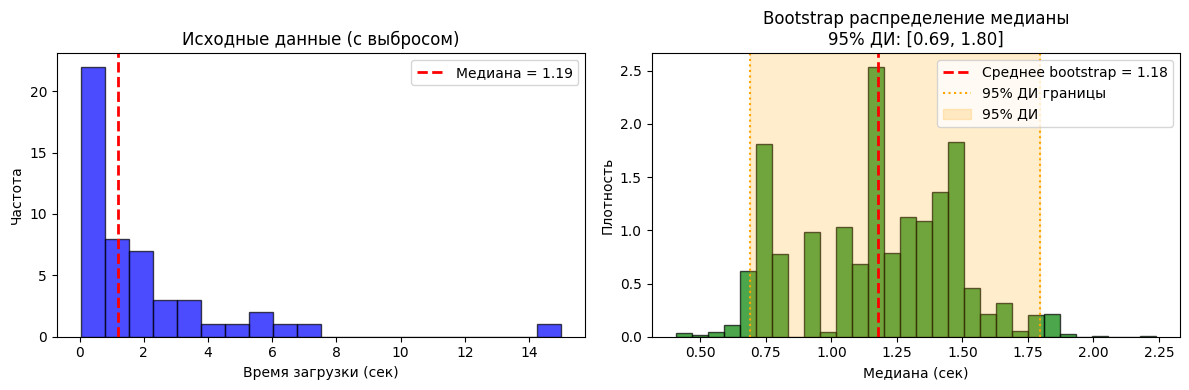

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def bootstrap_median(data, n_bootstrap=10000):
    """
    Оценка неопределенности медианы через bootstrap
    """
    n = len(data)
    bootstrap_medians = []

    for _ in range(n_bootstrap):
        # Выборка с возвращением (bootstrap sample)
        bootstrap_sample = np.random.choice(data, size=n, replace=True)
        # Вычисляем медиану для этой выборки
        bootstrap_medians.append(np.median(bootstrap_sample))

    return np.array(bootstrap_medians)

# Пример: время загрузки карты в Яндекс.Маршрутах
np.random.seed(42)
# Исходные данные (могут иметь выбросы)
load_times = np.random.exponential(2.0, 50)  # экспоненциальное распределение
load_times[0] = 15.0  # добавляем выброс

print(f"Исходные данные: n = {len(load_times)}")
print(f"Медиана: {np.median(load_times):.2f} сек")
print(f"Среднее: {np.mean(load_times):.2f} сек")
print(f"Выбросы: {np.sum(load_times > 10)} значений > 10 сек")

# Bootstrap оценка
bootstrap_medians = bootstrap_median(load_times, n_bootstrap=10000)

# Статистики
median_estimate = np.mean(bootstrap_medians)
se_median = np.std(bootstrap_medians)  # стандартная ошибка
ci_95 = np.percentile(bootstrap_medians, [2.5, 97.5])

print(f"\n📊 Bootstrap результаты (n={len(bootstrap_medians)}):")
print(f"Оценка медианы: {median_estimate:.2f} сек")
print(f"Стандартная ошибка: ±{se_median:.3f} сек")
print(f"95% доверительный интервал: [{ci_95[0]:.2f}, {ci_95[1]:.2f}] сек")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1. Исходные данные
axes[0].hist(load_times, bins=20, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(np.median(load_times), color='red', linestyle='--',
                linewidth=2, label=f'Медиана = {np.median(load_times):.2f}')
axes[0].set_xlabel('Время загрузки (сек)')
axes[0].set_ylabel('Частота')
axes[0].set_title('Исходные данные (с выбросом)')
axes[0].legend()

# 2. Bootstrap распределение медианы
axes[1].hist(bootstrap_medians, bins=30, alpha=0.7, color='green',
            edgecolor='black', density=True)
axes[1].axvline(median_estimate, color='red', linestyle='--',
                linewidth=2, label=f'Среднее bootstrap = {median_estimate:.2f}')
axes[1].axvline(ci_95[0], color='orange', linestyle=':',
                label='95% ДИ границы')
axes[1].axvline(ci_95[1], color='orange', linestyle=':')
axes[1].axvspan(ci_95[0], ci_95[1], alpha=0.2, color='orange', label='95% ДИ')
axes[1].set_xlabel('Медиана (сек)')
axes[1].set_ylabel('Плотность')
axes[1].set_title(f'Bootstrap распределение медианы\n95% ДИ: [{ci_95[0]:.2f}, {ci_95[1]:.2f}]')
axes[1].legend()

plt.tight_layout()
plt.show()

=== Bootstrap сравнение двух серверов ===
Сервер A: среднее = 1.216 сек, n = 100
Сервер B: среднее = 0.933 сек, n = 100
Наблюдаемая разница: -0.283 сек

📊 Bootstrap 95% ДИ для разницы: [-0.592, 0.021]
❌ 95% ДИ содержит 0 → нет статистически значимой разницы


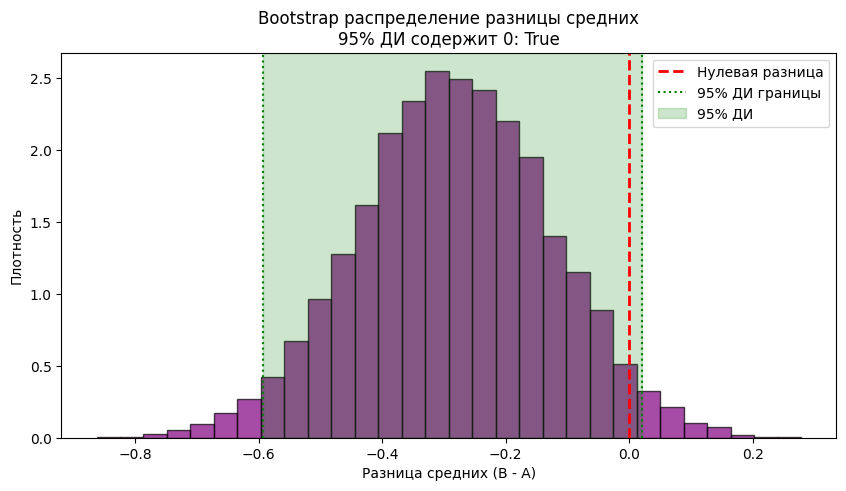

In [ ]:
def bootstrap_ci_diff(data_A, data_B, n_bootstrap=10000, alpha=0.05):
    """
    Bootstrap доверительный интервал для разницы средних
    """
    n_A = len(data_A)
    n_B = len(data_B)

    bootstrap_diffs = []

    for _ in range(n_bootstrap):
        # Bootstrap выборки для каждой группы
        sample_A = np.random.choice(data_A, size=n_A, replace=True)
        sample_B = np.random.choice(data_B, size=n_B, replace=True)

        # Разница средних
        diff = np.mean(sample_B) - np.mean(sample_A)
        bootstrap_diffs.append(diff)

    # Percentile bootstrap CI
    ci_lower = np.percentile(bootstrap_diffs, alpha/2 * 100)
    ci_upper = np.percentile(bootstrap_diffs, (1 - alpha/2) * 100)

    # Проверка гипотезы: CI содержит 0?
    contains_zero = ci_lower <= 0 <= ci_upper

    return np.array(bootstrap_diffs), ci_lower, ci_upper, contains_zero

# Пример: сравнение времени ответа двух серверов
server_A = np.random.exponential(1.0, 100)  # среднее 1.0 сек
server_B = np.random.exponential(1.2, 100)  # среднее 1.2 сек

bootstrap_diffs, ci_lower, ci_upper, contains_zero = bootstrap_ci_diff(
    server_A, server_B, n_bootstrap=10000, alpha=0.05
)

print("=== Bootstrap сравнение двух серверов ===")
print(f"Сервер A: среднее = {server_A.mean():.3f} сек, n = {len(server_A)}")
print(f"Сервер B: среднее = {server_B.mean():.3f} сек, n = {len(server_B)}")
print(f"Наблюдаемая разница: {server_B.mean() - server_A.mean():.3f} сек")
print(f"\n📊 Bootstrap 95% ДИ для разницы: [{ci_lower:.3f}, {ci_upper:.3f}]")

if contains_zero:
    print("❌ 95% ДИ содержит 0 → нет статистически значимой разницы")
else:
    if ci_lower > 0:
        print("✅ Сервер B значимо медленнее (все значения ДИ > 0)")
    elif ci_upper < 0:
        print("✅ Сервер A значимо медленнее (все значения ДИ < 0)")

# Визуализация
plt.figure(figsize=(10, 5))
plt.hist(bootstrap_diffs, bins=30, alpha=0.7, color='purple',
        edgecolor='black', density=True)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Нулевая разница')
plt.axvline(ci_lower, color='green', linestyle=':', label='95% ДИ границы')
plt.axvline(ci_upper, color='green', linestyle=':')
plt.axvspan(ci_lower, ci_upper, alpha=0.2, color='green', label='95% ДИ')
plt.xlabel('Разница средних (B - A)')
plt.ylabel('Плотность')
plt.title(f'Bootstrap распределение разницы средних\n95% ДИ содержит 0: {contains_zero}')
plt.legend()
plt.show()

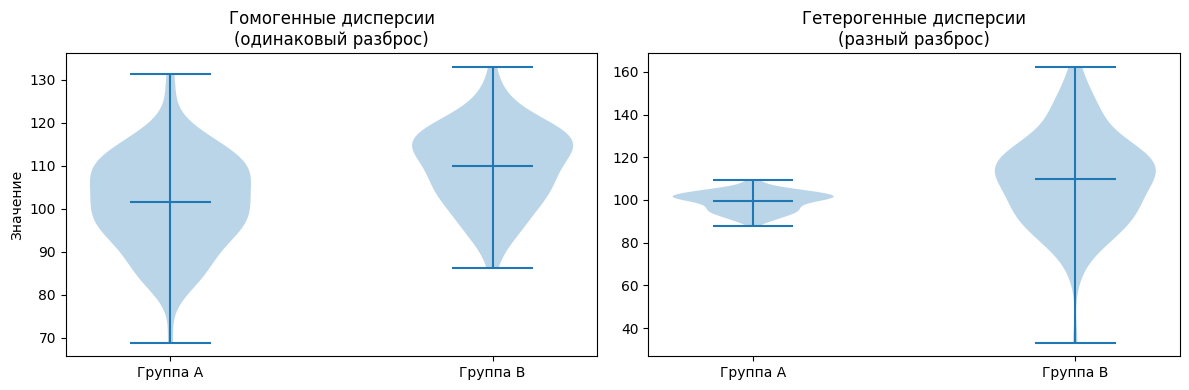

=== Гомогенные дисперсии ===
Группа A: var = 119.1, std = 10.9
Группа B: var = 87.2, std = 9.3
Отношение дисперсий: 0.73

=== Гетерогенные дисперсии ===
Группа A: var = 21.2, std = 4.6
Группа B: var = 459.1, std = 21.4
Отношение дисперсий: 21.62


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Пример 1: Гомогенные дисперсии (одинаковый разброс)
group_A_homo = np.random.normal(loc=100, scale=10, size=100)  # σ ≈ 10
group_B_homo = np.random.normal(loc=110, scale=10, size=100)  # σ ≈ 10

# Пример 2: Гетерогенные дисперсии (разный разброс)
group_A_hetero = np.random.normal(loc=100, scale=5, size=100)   # σ ≈ 5
group_B_hetero = np.random.normal(loc=110, scale=20, size=100)  # σ ≈ 20

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Гомогенные дисперсии
axes[0].violinplot([group_A_homo, group_B_homo], showmeans=True)
axes[0].set_title('Гомогенные дисперсии\n(одинаковый разброс)')
axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(['Группа A', 'Группа B'])
axes[0].set_ylabel('Значение')

# Гетерогенные дисперсии
axes[1].violinplot([group_A_hetero, group_B_hetero], showmeans=True)
axes[1].set_title('Гетерогенные дисперсии\n(разный разброс)')
axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(['Группа A', 'Группа B'])

plt.tight_layout()
plt.show()

# Расчет дисперсий
print("=== Гомогенные дисперсии ===")
print(f"Группа A: var = {np.var(group_A_homo):.1f}, std = {np.std(group_A_homo):.1f}")
print(f"Группа B: var = {np.var(group_B_homo):.1f}, std = {np.std(group_B_homo):.1f}")
print(f"Отношение дисперсий: {np.var(group_B_homo)/np.var(group_A_homo):.2f}")

print("\n=== Гетерогенные дисперсии ===")
print(f"Группа A: var = {np.var(group_A_hetero):.1f}, std = {np.std(group_A_hetero):.1f}")
print(f"Группа B: var = {np.var(group_B_hetero):.1f}, std = {np.std(group_B_hetero):.1f}")
print(f"Отношение дисперсий: {np.var(group_B_hetero)/np.var(group_A_hetero):.2f}")

In [ ]:
from scipy.stats import levene

# Проверка для гомогенных данных
stat_homo, p_homo = levene(group_A_homo, group_B_homo)
print(f"Тест Левена (гомогенные): W = {stat_homo:.3f}, p = {p_homo:.4f}")

# Проверка для гетерогенных данных
stat_hetero, p_hetero = levene(group_A_hetero, group_B_hetero)
print(f"Тест Левена (гетерогенные): W = {stat_hetero:.3f}, p = {p_hetero:.4f}")

# Интерпретация
alpha = 0.05
print(f"\nИнтерпретация (α = {alpha}):")
print(f"Гомогенные: p = {p_homo:.4f} {'>' if p_homo > alpha else '≤'} {alpha} → {'ОК' if p_homo > alpha else 'Проблема!'}")
print(f"Гетерогенные: p = {p_hetero:.4f} {'>' if p_hetero > alpha else '≤'} {alpha} → {'ОК' if p_hetero > alpha else 'Проблема!'}")

Тест Левена (гомогенные): W = 1.857, p = 0.1745
Тест Левена (гетерогенные): W = 86.560, p = 0.0000

Интерпретация (α = 0.05):
Гомогенные: p = 0.1745 > 0.05 → ОК
Гетерогенные: p = 0.0000 ≤ 0.05 → Проблема!


In [ ]:
pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.7 MB/s eta 0:00:00


In [ ]:
# Используем pingouin или statsmodels
import pingouin as pg

# Пример с тремя группами
group1 = np.random.normal(100, 5, 30)
group2 = np.random.normal(110, 10, 30)  # большая дисперсия
group3 = np.random.normal(105, 15, 30)  # еще больше дисперсия

# Собираем данные в DataFrame
import pandas as pd
df = pd.DataFrame({
    'value': np.concatenate([group1, group2, group3]),
    'group': ['A']*30 + ['B']*30 + ['C']*30
})

# Welch's ANOVA
welch_result = pg.welch_anova(data=df, dv='value', between='group')
print("Welch's ANOVA:")
print(welch_result)

Welch's ANOVA:
  Source  ddof1      ddof2          F     p-unc       np2
0  group      2  47.610841  17.373646  0.000002  0.152185


In [ ]:
# Для двух групп: Mann-Whitney U test
u_stat, p_mw = stats.mannwhitneyu(group_A_hetero, group_B_hetero)

# Для 3+ групп: Kruskal-Wallis test
h_stat, p_kw = stats.kruskal(group1, group2, group3)

print(f"\nНепараметрические альтернативы:")
print(f"Mann-Whitney: p = {p_mw:.4f}")
print(f"Kruskal-Wallis: p = {p_kw:.4f}")


Непараметрические альтернативы:
Mann-Whitney: p = 0.0000
Kruskal-Wallis: p = 0.0002


=== Проверка гомогенности дисперсий ===
Тест Левена: W = 7.664, p = 0.0001

Стандартные отклонения:
  Москва: 1.83 сек
  СПб: 2.26 сек
  Казань: 2.78 сек
  Екатеринбург: 3.63 сек

max/std/min = 1.98
Правило 2x: Гомогенны (порог ≤ 2)


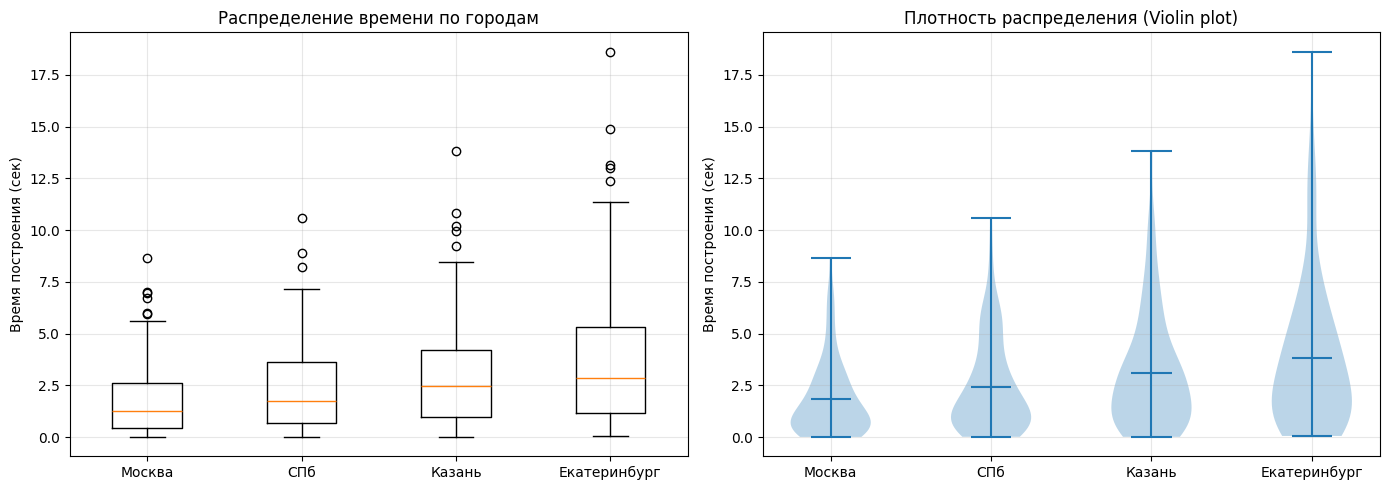


=== Выбор статистического теста ===
❌ Дисперсии гетерогенны
   НЕЛЬЗЯ использовать обычную ANOVA

   Welch's ANOVA: F = 10.061, p = 0.0000
   Kruskal-Wallis: H = 22.270, p = 0.0001
   Есть статистически значимые различия

   Попарные сравнения (Mann-Whitney с поправкой Бонферрони):
   Число сравнений: 6, α = 0.0083
   Москва vs СПб: p = 0.0528 ✗
   Москва vs Казань: p = 0.0005 ✓
   Москва vs Екатеринбург: p = 0.0000 ✓
   СПб vs Казань: p = 0.1071 ✗
   СПб vs Екатеринбург: p = 0.0110 ✗
   Казань vs Екатеринбург: p = 0.2699 ✗


In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Генерируем данные для 4 городов
np.random.seed(42)

# Разное время и разная вариабельность
data = {
    'Москва': np.random.exponential(2.0, 100),      # быстрее, меньше разброс
    'СПб': np.random.exponential(2.5, 100),         # медленнее
    'Казань': np.random.exponential(3.0, 100),      # еще медленнее
    'Екатеринбург': np.random.exponential(4.0, 100) # медленно, большой разброс
}

# Проверяем гомогенность дисперсий
print("=== Проверка гомогенности дисперсий ===")

# 1. Тест Левена
lev_stat, lev_p = levene(*data.values())
print(f"Тест Левена: W = {lev_stat:.3f}, p = {lev_p:.4f}")

# 2. Правило большого пальца
stds = {city: np.std(times) for city, times in data.items()}
max_std = max(stds.values())
min_std = min(stds.values())
ratio = max_std / min_std

print(f"\nСтандартные отклонения:")
for city, std in stds.items():
    print(f"  {city}: {std:.2f} сек")
print(f"\nmax/std/min = {ratio:.2f}")
print(f"Правило 2x: {'Гомогенны' if ratio <= 2 else 'Гетерогенны'} (порог ≤ 2)")

# 3. Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
ax1.boxplot(data.values())
ax1.set_xticklabels(data.keys())
ax1.set_ylabel('Время построения (сек)')
ax1.set_title('Распределение времени по городам')
ax1.grid(True, alpha=0.3)

# Violin plot
parts = ax2.violinplot(data.values(), showmeans=True)
ax2.set_xticks(range(1, len(data)+1))
ax2.set_xticklabels(data.keys())
ax2.set_ylabel('Время построения (сек)')
ax2.set_title('Плотность распределения (Violin plot)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Выбор статистического теста
print("\n=== Выбор статистического теста ===")

if lev_p > 0.05 and ratio <= 2:
    print("✅ Дисперсии гомогенны")
    print("   Можно использовать ANOVA")

    # One-way ANOVA
    f_stat, p_anova = stats.f_oneway(*data.values())
    print(f"   ANOVA: F = {f_stat:.3f}, p = {p_anova:.4f}")

    if p_anova < 0.05:
        print("   Есть статистически значимые различия между городами")

        # Post-hoc тест (Tukey HSD)
        from statsmodels.stats.multicomp import pairwise_tukeyhsd

        # Подготовка данных для Tukey
        values = np.concatenate(list(data.values()))
        groups = np.repeat(list(data.keys()), [len(v) for v in data.values()])

        tukey = pairwise_tukeyhsd(values, groups, alpha=0.05)
        print("\n   Попарные сравнения (Tukey HSD):")
        print(tukey)

else:
    print("❌ Дисперсии гетерогенны")
    print("   НЕЛЬЗЯ использовать обычную ANOVA")

    # Альтернатива 1: Welch's ANOVA
    try:
        import pingouin as pg

        # Подготовка DataFrame
        df_list = []
        for city, times in data.items():
            for time in times:
                df_list.append({'city': city, 'time': time})
        df = pd.DataFrame(df_list)

        welch_result = pg.welch_anova(data=df, dv='time', between='city')
        print(f"\n   Welch's ANOVA: F = {welch_result['F'].values[0]:.3f}, "
              f"p = {welch_result['p-unc'].values[0]:.4f}")

    except ImportError:
        print("   Установите pingouin для Welch's ANOVA")

    # Альтернатива 2: Kruskal-Wallis (непараметрический)
    h_stat, p_kw = stats.kruskal(*data.values())
    print(f"   Kruskal-Wallis: H = {h_stat:.3f}, p = {p_kw:.4f}")

    if p_kw < 0.05:
        print("   Есть статистически значимые различия")

        # Post-hoc для Kruskal-Wallis (Mann-Whitney с поправкой)
        from itertools import combinations

        cities = list(data.keys())
        n_comparisons = len(list(combinations(cities, 2)))
        bonferroni_alpha = 0.05 / n_comparisons

        print(f"\n   Попарные сравнения (Mann-Whitney с поправкой Бонферрони):")
        print(f"   Число сравнений: {n_comparisons}, α = {bonferroni_alpha:.4f}")

        for city1, city2 in combinations(cities, 2):
            u_stat, p_pair = stats.mannwhitneyu(data[city1], data[city2])
            significant = p_pair < bonferroni_alpha
            symbol = '✓' if significant else '✗'
            print(f"   {city1} vs {city2}: p = {p_pair:.4f} {symbol}")